In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

In [111]:
#Read the csv file
df = pd.read_csv("yelp_data_official_training.csv", low_memory=False, delimiter='|')
df.head()

,ID,Category,Review Text
0,0,2,Don't waste your time. We had two different p...
1,1,2,I will start by saying we have a nice new deck...
2,2,2,When I wanted a deck for the back of my home I...
3,3,5,Our cat went out the other night and must have...
4,4,5,Greentree Animal clinic is the absolute best! ...


In [112]:
#Take out NaN
filtered_data = df["Review Text"].notnull()
df_filtered = df[filtered_data]

#Shuffle the data
random_index = np.random.permutation(df_filtered.index)
df_shuffled = df.ix[random_index, ['Category', 'Review Text']]
df_shuffled.reset_index(drop=True, inplace=True)
df_shuffled[:5]

,Category,Review Text
0,3,My husband had to have surgery on his spine. W...
1,4,I had a guy that was really just not friendly....
2,2,I have a friend that moved in last June. I am ...
3,1,"Every time I use this pharmacy, I wait a coupl..."
4,2,These guys are liars. A boy from this company ...


we shuffle the rows and create train and dev sets 

In [113]:
#Split the data into train and dev
rows, columns = df_shuffled.shape
train_size = round(rows*.7)
dev_size   = round(rows*.3)


df_train = df_shuffled.loc[:train_size]
df_dev = df_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)

## Train the data

Following is the same code from Scikit-Learn notebook

In [114]:
#features
def unigram_feature(x, unigram):
    if(type(x) == float):
        print(x)
    word_list = x.lower().split(" ")
    return word_list.count(unigram)

def bigram_feature(x, bigram):
    bigram_tuple = tuple(bigram.split())
    word_list = x.lower().split(" ")
    bi = nltk.FreqDist(nltk.bigrams(word_list))
    return bi[bigram_tuple]

In [115]:
#Running features on train set
train_doctor_feature = df_train['Review Text'].apply(lambda x: unigram_feature(x, ('dr')))
train_dry_cleaning_feature = df_train['Review Text'].apply(lambda x: bigram_feature(x, ('dry cleaning')))

In [116]:
df_train_features = pd.DataFrame({'doctor': train_doctor_feature,
                                 'dry cleaning': train_dry_cleaning_feature })

In [117]:
dev_doctor_feature = df_dev['Review Text'].apply(lambda x: unigram_feature(x, ('dr')))
dev_dry_cleaning_feature = df_dev['Review Text'].apply(lambda x: bigram_feature(x, ('dry cleaning')))

In [118]:
df_dev_features = pd.DataFrame({'doctor': dev_doctor_feature,
                               'dry cleaning': dev_dry_cleaning_feature})

## Build the model

We build a model using naive beyes model with count vectorizer that treats the reviews as a bag of words

In [119]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb = MultinomialNB()
nb_model = nb.fit(df_train_features, df_train.Category)
nb_predictions = nb_model.predict(df_dev_features)

accuracy_score(df_dev.Category, nb_predictions)


0.32215277777777779

In [120]:
df_test = pd.read_csv("yelp_data_official_test_nocategories.csv", low_memory=False, delimiter='|')
df_test.head()

,ID,Review Text
0,0,We had the same doctor in Houston for over 12 ...
1,1,My mother passed away recently at the age of 9...
2,2,"Updating! So, the dispute was resolved at this..."
3,3,We just moved here from WA and are looking for...
4,4,They have lost the best of the best. The last ...


Using n-gram between 1 to 2 values (i.e. unigrams and bigrams) with a simplified token pattern to find ngrams that occur more than 3 times in the collection. We also cap our features to the top 2000 most common n-grams using the max_features variable within the CountVectorizer() function.

#### Robin's Note: changing 1000 most common to 2000 most common n-grams improved the score by 3%

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

#building a vector tokenizer
vec = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=3, stop_words='english', max_features=5000)

tokenizer = vec.build_tokenizer()

arr_train_feature_sparse = vec.fit_transform(df_train['Review Text'])
arr_train_feature = arr_train_feature_sparse.toarray()
print("the size of the vector the training set is as follows: {}".format(arr_train_feature.shape))

arr_dev_feature_sparse = vec.transform(df_dev["Review Text"])
arr_dev_feature = arr_dev_feature_sparse.toarray()
print("the size of the vector the development set is as follows: {}".format(arr_dev_feature.shape))

the size of the vector the training set is as follows: (33600, 5000)
the size of the vector the development set is as follows: (14400, 5000)


In [135]:
feature_sum = arr_train_feature.sum(axis=0)   #sum the counts of each feature

df_feature_sum = pd.DataFrame({'counts': feature_sum})
df_feature_sum.index = vec.get_feature_names()

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]


Robin: Here we remove one letter words e.g. "S" or "T" or "0" that may not be relevant for our discussion


In [139]:
df_feature_sum = df_feature_sum[df_feature_sum.index.map(len) > 1]
df_feature_sum.shape

(4967, 1)

Robin: Here we remove any words that may contain letters. "0" "00" or "1 star" are not valuable for our use case
source: http://stackoverflow.com/questions/31539187/remove-rows-from-dataframe-that-contain-numbers-from-0-to-9

In [140]:
df_feature_sum = df_feature_sum[~df_feature_sum.index.str.contains('\d')]
df_feature_sum.shape

(4810, 1)

In [149]:
df_feature_sum[20:70]

,tag
20,"[(a, DT), (c, JJ), (c, NN), (o, NN), (u, JJ), ..."
21,"[(a, DT), (c, JJ), (c, NN), (u, JJ), (r, NN), ..."
22,"[(a, DT), (c, NN), (e, NN)]"
23,"[(a, DT), (c, JJ), (k, NN), (n, JJ), (o, NN), ..."
24,"[(a, DT), (c, JJ), (k, NN), (n, JJ), (o, NN), ..."
25,"[(a, DT), (c, JJ), (r, NN), (y, NN), (l, NN), ..."
26,"[(a, DT), (c, JJ), (r, NN), (y, NN), (l, NN), ..."
27,"[(a, DT), (c, NN), (t, NN)]"
28,"[(a, DT), (c, JJ), (t, NN), ( , NNP), (l, NN),..."
29,"[(a, DT), (c, JJ), (t, NN), (e, NN), (d, NN)]"


C:\Users\Robin Oh\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


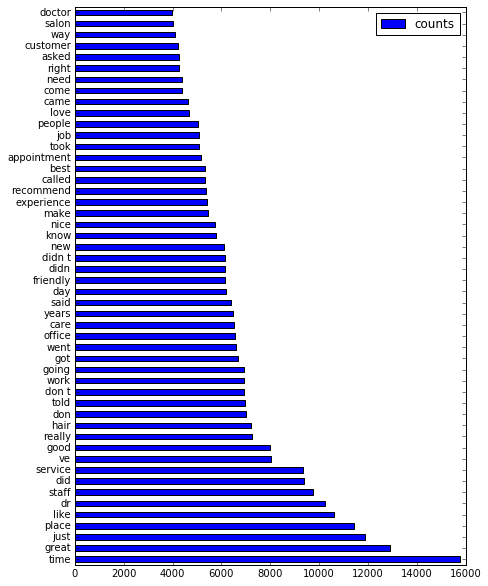

In [126]:
df_feature_sum.sort('counts', ascending=False)[:50].plot(kind='barh', figsize=(7,10));

In [127]:
nb = MultinomialNB()
nb_model = nb.fit(arr_train_feature, df_train.Category)
nb_predictions = nb_model.predict(arr_dev_feature)
accuracy_score(df_dev.Category, nb_predictions)

0.87979166666666664

In [128]:
df_test.head()

,ID,Review Text
0,0,We had the same doctor in Houston for over 12 ...
1,1,My mother passed away recently at the age of 9...
2,2,"Updating! So, the dispute was resolved at this..."
3,3,We just moved here from WA and are looking for...
4,4,They have lost the best of the best. The last ...


In [129]:
arr_test_feature_sparse = vec.transform(df_test['Review Text'])
arr_test_feature = arr_test_feature_sparse.toarray()
nb_test_predictions = nb_model.predict(arr_test_feature)


In [130]:
final_test_predictions = pd.DataFrame( {'Category': nb_test_predictions})

In [131]:
final_test_predictions.to_csv('yelp_data_official_test_submission.csv', header=True, index=True)

In [132]:
final_test_predictions.head()


,Category
0,3
1,3
2,3
3,3
4,1


In [133]:
df_test.head()

,ID,Review Text
0,0,We had the same doctor in Houston for over 12 ...
1,1,My mother passed away recently at the age of 9...
2,2,"Updating! So, the dispute was resolved at this..."
3,3,We just moved here from WA and are looking for...
4,4,They have lost the best of the best. The last ...


Lets create more meaningful features.
1) Create hypernyms for 